## MultiModal RAG Agent with Tavily

#### RAG Data Ingestion

In [94]:
from dotenv import load_dotenv
load_dotenv()
from unstructured.partition.pdf import partition_pdf
import os
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
import uuid
from langchain_astradb import AstraDBVectorStore
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from pydantic import BaseModel, Field
from typing import Annotated, TypedDict, Literal
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import  AnyMessage, add_messages
import operator
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.output_parsers import PydanticOutputParser
import warnings
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from base64 import b64decode
warnings.filterwarnings('ignore')

In [2]:
## Document Loading and Chunking

file_path = 'content//attention.pdf'

def partition_and_chunk(file_path):
    """Partitions and chunks a PDF file into manageable pieces. """
    
    chunks = partition_pdf(
        filename=file_path,
        strategy='hi_res',
        infer_table_structure=True,
        
        extract_image_block_types=['Image'],
        extract_image_block_to_payload=True,
        
        chunking_strategy='by_title',
        max_characters = 2000,
        combine_text_under_n_chars = 500,
        new_after_n_chars = 6000,
    )
    
    return chunks

In [3]:
chunks = partition_and_chunk(file_path)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [4]:
## Extract text
texts = [chunk for chunk in chunks if 'CompositeElement' in str(type(chunk))]
## getting base64 object of image
images = [ el.metadata.image_base64 for chunk in chunks for el in chunk.metadata.orig_elements if 'Image' in str(type(el)) ]

In [5]:
prompt_text = '''
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything similar.
just give the summary as it is.

Table or text chunk: {element}
'''

prompt_image = """Describe the image in detail. Be specific about the architecture, graphs, plots such as bar plot"""
image_message = [
    (
        "user",
        [
         {'type':'text', 'text':prompt_image},
         {'type':'image_url','image_url':{'url':'data:image/jpeg;base64,{image}'},}, 
        ]
    )
]

llm = ChatOpenAI(model = 'gpt-4o-mini')

In [6]:
## get summary of text and images
def summary_for_vs(chunks, texts = texts, images = images):
    
    image_prompt_template = ChatPromptTemplate.from_messages(image_message)
    image_chain = image_prompt_template | llm | StrOutputParser()
    
    text_prompy_template = ChatPromptTemplate.from_template(prompt_text)
    text_chain = text_prompy_template | llm | StrOutputParser()
    
    text_summary = text_chain.batch(texts)
    image_summary = image_chain.batch(images)
    
    return text_summary,image_summary
    

In [7]:
text_summary, image_summary = summary_for_vs(chunks)

In [8]:
token = os.getenv('ASTRA_DB_APPLICATION_TOKEN')
namespace = os.getenv('ASTRA_DB_KEYSPACE')
endpoint = os.getenv('ASTRA_DB_API_ENDPOINT')
embedding = OpenAIEmbeddings(model="text-embedding-3-small")

In [9]:
## The vector store to index the summary chunks
vector_store = AstraDBVectorStore(
    embedding=embedding,
    collection_name="RAG_Graph",
    api_endpoint=endpoint,
    token=token,
    namespace=namespace,
)

## The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

## The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vector_store,  ## The vector store to index the summary chunks
    docstore=store,            ## The storage layer for the parent documents
    id_key=id_key,
)


In [11]:
## adding image summries
def loading_summaries_to_vector_store(retriever, chunks, chunk_summary):
    """
        Generate ids for each chunk, create langchain document object for each summry chunk.
        Indexing the summary in vector store and document in docsotre.
    """
    ## generate unique id for each chunk
    doc_ids = [str(uuid.uuid4()) for _ in chunks]
    ## Creating Langchain Document objects for each text_summary chunk
    summary_texts = [Document(page_content=summary,metadata={id_key:doc_ids[i]}) for i,summary in enumerate(chunk_summary)]
    
    ## indexing the documents in vector store and document store
    retriever.vectorstore.add_documents(summary_texts)
    retriever.docstore.mset(list(zip(doc_ids,chunks)))

In [12]:
## adding text summaries to vector store and document store
loading_summaries_to_vector_store(retriever,texts,text_summary)
## adding image summaries to vector store and document store
loading_summaries_to_vector_store(retriever,images,image_summary)
## Now the retriever is ready to use

## Agent

In [14]:
## Creating Pydantic class

class RouterCall_Output(BaseModel):
    Topic: Literal['Related','Not Related'] = Field(description="Classification of the user query")
    Reasoning: str = Field(description='Reasoning behind topic selection')
    
parser = PydanticOutputParser(pydantic_object=RouterCall_Output)

In [139]:
## State class
class State(TypedDict):
    messages : Annotated[list[AnyMessage], operator.add]

In [140]:
## Supervisor Function
def supervisor(state:State):
    
    question = state['messages'][-1]
    print(question)
    
    template = '''
    You are an expert in routing. Your task is to classify if the given user query is related to LLM Transformer architecture.
    You must classify as either "Related" or "Not Related".
    Provide a brief reasoning for your classification.
    
    user query : {question}
    {format_instructions}
    '''
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['question'],
        partial_variables={'format_instructions':parser.get_format_instructions()}
    )
    
    chain = prompt | llm | parser
    response = chain.invoke({'question':question})
    print("Parsed response:", response)
    
    return {'messages':[response.Topic]}

In [141]:
## Router function
def router(state: State):
    print('-->Router-->')
    
    last_message = state['messages'][-1]
    print("last_message: ",last_message)
    
    if  last_message == 'Related':
        return 'RAG Call'
    else:
        return 'LLM Call'

In [142]:
## RAG Function
def rag_function(state:State):
    print('-->RAG-->')
    
    question = state['messages'][0]
    
    def parse_doc(docs):
        '''Parses the retrieved documents to return a dictionary with text and images'''
        image_docs = []
        text_docs = []
        for doc in docs:
            try:
                b64decode(doc)
                image_docs.append(doc)
            except Exception as e:
                text_docs.append(doc)
        return {'images': image_docs,'texts':text_docs}
    
    def built_prompt(kwargs):
        '''Builds the prompt for the model using the context and question.'''
        

        docs_by_type = kwargs['context']
        user_question = kwargs['question']
        
        ## concatenate all the text
        context_text = ''
        if len(docs_by_type['texts'])>0:
            for el in docs_by_type['texts']:
                context_text += el.text
        
        prompt_template = f'''
        Answer the question based on following cotext, which can include text and images.
        Context : {context_text}
        Question : {user_question}'''
        
        prompt_content = [{'type':'text', 'text':prompt_template}]
        
        if len(docs_by_type['images'])>0:
            for img in docs_by_type['images']:
                prompt_content.append(
                    {'type':'image_url','image_url':{'url':f'data:image/jpeg;base64,{img}'}},
                )

        ## return prompt
        return ChatPromptTemplate.from_messages([HumanMessage(content=prompt_content)])

    
    chain = (
        {'context': retriever | RunnableLambda(parse_doc), 'question':RunnablePassthrough()}
        |RunnableLambda(built_prompt)
        |llm
        |StrOutputParser()
        
    )
    result = chain.invoke(question)
    return {'messages':[result]}

In [176]:
tavily_tool = TavilySearchResults(max_results=3)
## Binding tavily tool with llm
llm_with_tool = llm.bind_tools([tavily_tool])
## ToolNode runs the tools which are called in last AIMessage
## If there are multiple tools called, it will run in parallel
tool_call = ToolNode([tavily_tool])

def llm_function(state:State):
    print('-->LLM Call-->')
    question = state['messages']
    
    print(question)

    complete_query = f'''
    You are an helpful assistant. Answer the question with with best of your knowledge. Following is the user question: {question}
    '''
    
    response = llm_with_tool.invoke(complete_query)

    return {'messages':[response]}

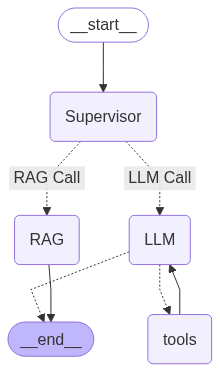

In [177]:
## Create Graph
build = StateGraph(State)
build.add_node('Supervisor',supervisor)
build.add_node('LLM',llm_function)
build.add_node('tools',tool_call)
build.add_node('RAG', rag_function)

build.add_edge(START, 'Supervisor')
build.add_conditional_edges(
    "Supervisor",
    router,
    {
        'RAG Call':'RAG',
        'LLM Call':'LLM'
    }
)
build.add_conditional_edges(
    'LLM',
    tools_condition
)
build.add_edge('tools','LLM')
build.add_edge('RAG',END)
#build.add_edge('LLM',END)
app = build.compile()
app

In [206]:
msg = app.invoke({'messages':['Air India crash']})
if 'Related' in msg['messages']:
    print(msg['messages'][-1])
else:
    print(msg['messages'][-1].content)

Air India crash
Parsed response: Topic='Not Related' Reasoning="The query 'Air India crash' pertains to an aviation incident and does not involve the LLM Transformer architecture, which is related to machine learning and natural language processing."
-->Router-->
last_message:  Not Related
-->LLM Call-->
['Air India crash', 'Not Related']
-->LLM Call-->
['Air India crash', 'Not Related', AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tbVD4P0cNnd3vgRfsWl0RjIG', 'function': {'arguments': '{"query":"Air India crash"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 113, 'total_tokens': 133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34